# Analysis of Chicago Parking Tickets Data

by *Xin Ma* 

SNR Lab  
Electrical and Computer Engineerng,  
University of Massachusetts

## Benefits and Broad Impact:
* Comprehensive understanding parking ticket problems in Chicago   


* Help improvement of parking facilities  


* Help improvement and advertisement of parking related Apps  


* Reduce parking tickets  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import geocoder
import requests

## Data Sets: 
* City of Chicago Parking Ticket data: (https://www.propublica.org/datastore/dataset/chicago-parking-ticket-data)  
    * Year 2007 ~ 2018  
      
    * Size 7.7 GB, 23 dimensions, 28,272,580 examples  


* Chicago Sensus Tract data: 3.5 MB.(https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik)


* Chicago Street Center data: 42MB. (https://data.cityofchicago.org/Transportation/Street-Center-Lines/6imu-meau)


* Scrape review data from ParkChicago App (https://play.google.com/store/apps/details?id=com.passportparking.mobile.parkchicago)

In [2]:
filename = 'parking_tickets.csv'
violations_all = pd.DataFrame()


chunk_size = 100000
for data in pd.read_csv(filename, chunksize = chunk_size,low_memory=False):
    data = data[~data.violation_description.str.contains("EXPIRED PLATES OR TEMPORARY REGISTRATION")]
    data = data[~data.violation_description.str.contains("EXPIRED PLATE OR TEMPORARY REGISTRATION")]
    violations = data['violation_description']
    violations_all = pd.concat([violations_all,violations])
    
violations_all.columns=['violation_description']
    
vio = violations_all['violation_description']
vio_count = vio.value_counts()


exp_meter_total = vio_count['EXPIRED METER OR OVERSTAY'] + \
                vio_count['EXP. METER NON-CENTRAL BUSINESS DISTRICT'] +\
                vio_count['EXPIRED METER CENTRAL BUSINESS DISTRICT']

exp_meter_total = pd.Series(exp_meter_total, index=['EXPIRED METER'])

vio_count = vio_count.append(exp_meter_total)
vio_count = vio_count.sort_values(ascending=False)   

vio_count = vio_count.drop(labels=['EXPIRED METER OR OVERSTAY',
                            'EXP. METER NON-CENTRAL BUSINESS DISTRICT',
                            'EXPIRED METER CENTRAL BUSINESS DISTRICT'])

Chicago parking ticket data examples:

In [3]:
data_example = pd.read_csv(filename, nrows=20)
data_example.head()

,ticket_number,issue_date,violation_location,license_plate_number,license_plate_state,license_plate_type,zipcode,violation_code,violation_description,unit,...,fine_level2_amount,current_amount_due,total_payments,ticket_queue,ticket_queue_date,notice_level,hearing_disposition,notice_number,officer,address
0,51551278,2007-01-01 00:00:00,6014 W 64TH ST,90ad622c3274c9bdc9d8c812b79a01d0aaf7479f2bd743...,IL,PAS,60638.0,0976160F,EXPIRED PLATES OR TEMPORARY REGISTRATION,8,...,100,0,100,Paid,2007-05-21 00:00:00,SEIZ,NaN,5048648030,15227,"6000 w 64th st, chicago, il"
1,51491256,2007-01-01 00:00:00,530 N MICHIGAN,bce4dc26b2c96965380cb2b838cdbb95632b7b57160612...,IL,PAS,606343801.0,0964150B,PARKING/STANDING PROHIBITED ANYTIME,18,...,100,50,0,Define,2007-01-22 00:00:00,NaN,NaN,0,18320,"500 n michigan, chicago, il"
2,50433524,2007-01-01 00:01:00,4001 N LONG,44641e828f4d894c883c07c566063c2d99d08f2c03b3d4...,IL,PAS,60148.0,0976160F,EXPIRED PLATES OR TEMPORARY REGISTRATION,16,...,100,0,50,Paid,2007-01-31 00:00:00,VIOL,NaN,5079875240,3207,"4000 n long, chicago, il"
3,51430906,2007-01-01 00:01:00,303 E WACKER,eee50ca0d9be2debd0e7d45bad05b8674a6cf5b892230f...,IL,PAS,60601.0,0964110A,DOUBLE PARKING OR STANDING,152,...,200,0,100,Paid,2007-03-08 00:00:00,DETR,Liable,5023379950,19410,"300 e wacker, chicago, il"
4,51507779,2007-01-01 00:01:00,7 E 41ST ST,244116ca3eed4235b1f61f6d753d8c688be2a48c9fdd97...,IL,PAS,605053013.0,0976220B,SMOKED/TINTED WINDOWS PARKED/STANDING,2,...,50,0,50,Paid,2007-08-29 00:00:00,SEIZ,NaN,5079891400,66396,"7 e 41st st, chicago, il"


In [4]:
# Prepare the concerned data by running proj_2_pre.py first
# Parse the recent 5 years history from the raw data
year_vec = ['2012','2013','2014','2015','2016','2017']
numTickets = pd.DataFrame(columns = ['time', 'number'])

In [5]:
k = 0
for i in range(len(year_vec)):

    year = year_vec[i]

    filename_c = 'issue_' + year + '.csv'
    data = pd.read_csv(filename_c, sep=',',low_memory=False) 
    
    data = data[~data.violation_description.str.contains("EXPIRED PLATE OR TEMPORARY REGISTRATION")]
    
    violations = data['violation_description']
    vio_cont = violations.value_counts()
    
    
    vio_meter = vio_cont['EXP. METER NON-CENTRAL BUSINESS DISTRICT'] +\
                vio_cont['EXPIRED METER CENTRAL BUSINESS DISTRICT']
                
    vio_total = len(violations)
    
    vioRate_meter = vio_meter/ vio_total
    
    #print('Meter violation rate = ' + str(vioRate_meter))
    
    # put expired meters violation in a dataframe
    searchfor = ['EXP. METER NON-CENTRAL BUSINESS DISTRICT',
                 'EXPIRED METER CENTRAL BUSINESS DISTRICT']
    meters = data[data.violation_description.str.contains('|'.join(searchfor))]
    
    
    
    ### see data by months
    
    vio_months = []
    for i in range(1, 13):
        if i < 10:
            month = ('0'+str(i))
        else:
            month = (str(i)) 
            
        time_str = year +'-'+ month  
        
        
        #data_tmp = full_df.loc[full_df.issue_date.str.contains(time_str)]
        data_tmp = meters.loc[meters.issue_date.str.contains(time_str)]
        
        vio_months.append([time_str, data_tmp])
        #print(time_str, len(data_tmp))
        
    # calculate tickets number by months
    #numTickets = []    
    for i in range(len(vio_months)):
        num = len(vio_months[i][1])
        time_str = vio_months[i][0]
        #numTickets.append([time_str, num])
        item = [time_str, num]
        
        k += 1
        numTickets.loc[k] = item



## Fact 1: Expried meter tickets rank the highest among 130 types of parking tickets (16%)

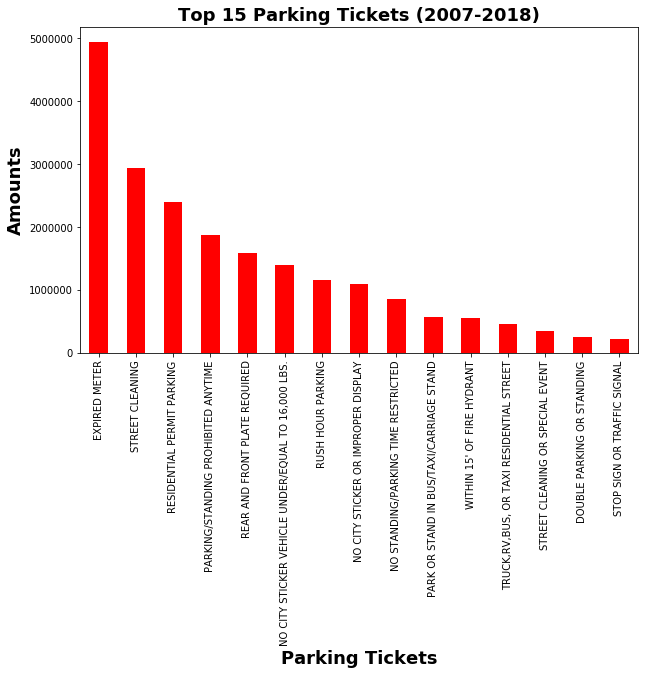

In [6]:
fig, ax = plt.subplots(figsize = (10,6))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Parking Tickets', fontsize=18, fontweight='bold')
ax.set_ylabel('Amounts' , fontsize=18, fontweight='bold')
ax.set_title('Top 15 Parking Tickets (2007-2018)', fontsize=18, fontweight='bold')
vio_count[:15].plot(ax=ax, kind='bar', color='red')
plt.show()

## Fact 2: Decreasing Trend of Expired Meter Tickets (Might due to ParkChicago App)

Now Visualize the trend of amount of expired meter tickets by month. It has the trend to decrease over time. The major reason might be the utilization of "ParkChicago" since 2014.

* Use linear regression to see the overall trend. 
* Use Kernel ridge regression to see the nonlinear variations of the trend.

In [7]:
from pandas_datareader import fred

numTickets = numTickets.drop(numTickets.index[0:2])
numTickets = numTickets.drop(numTickets.index[-4:])
# ax = numTickets.number.plot(xticks= numTickets.index[1:len(numTickets.index):12], rot=90, figsize=(10,6))
# ax.set_xticklabels(numTickets.time[1:len(numTickets):12],rotation=90)
# plt.tight_layout()
# plt.xlabel('Time',fontsize=18)
# plt.ylabel('Amount',fontsize=18)
# plt.title('Monthly Amount of Issued Tickets for Expired Meters', fontsize = 18)

# Conduct linear regression
from sklearn.linear_model import LinearRegression
X = []
Y = []

for i in range(len(numTickets)):
    x = i
    y = numTickets.iloc[i][1]
    X.append([x])
    Y.append(y)
    
X_train = np.array(X)
Y_train = np.array(Y)    

# training
reg = LinearRegression().fit(X, Y)

Y_test = reg.predict(X_train)

Y_pred = pd.DataFrame(Y_test, index=numTickets.index)

#numTickets.join(Y_pred, ignore_index=True)
numTickets2 = pd.concat([numTickets, Y_pred],  axis=1)
numTickets2.columns = ['time', 'number','pred']

# conduct kernel ridge regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

clf = KernelRidge(alpha = 0.1)
reg2 = clf.fit(X_train, Y_train)
Y_test2 = reg2.predict(X_train)
Y_pred2 = pd.DataFrame(Y_test2, index=numTickets.index)

#plt.plot(Y_test2)
#plt.show()

param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}           
  
kr = GridSearchCV(KernelRidge(), cv=15, param_grid=param_grid)
reg3 = kr.fit(X_train, Y_train)
Y_test3 = reg3.predict(X_train)
Y_pred2 = pd.DataFrame(Y_test3, index=numTickets.index)

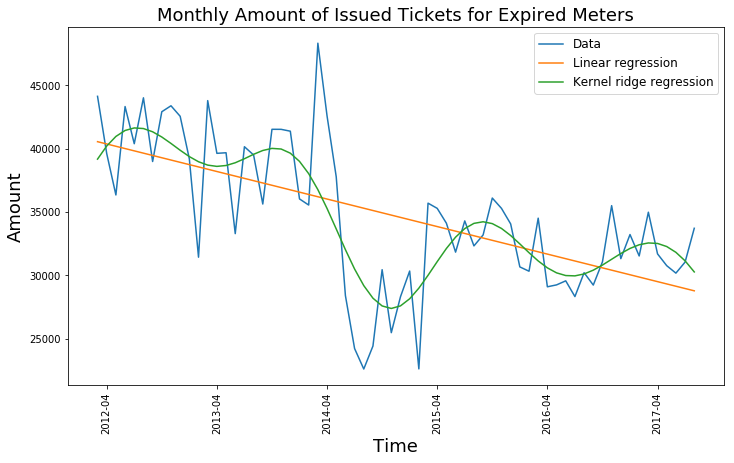

In [8]:
numTickets3 =  pd.concat([numTickets2, Y_pred2], axis=1)
numTickets3.columns = ['time', 'number','pred','pred2']


ax = numTickets3.number.plot(xticks= numTickets3.index[1:len(numTickets3.index):12], rot=90, figsize=(10,6))
ax = numTickets3.pred.plot(xticks= numTickets3.index[1:len(numTickets3.index):12], rot=90, figsize=(10,6))
ax = numTickets3.pred2.plot(xticks= numTickets3.index[1:len(numTickets3.index):12], rot=90, figsize=(10,6))
ax.set_xticklabels(numTickets2.time[1:len(numTickets):12],rotation=90)
plt.tight_layout()
plt.xlabel('Time',fontsize=18)
plt.ylabel('Amount',fontsize=18)
plt.title('Monthly Amount of Issued Tickets for Expired Meters', fontsize = 18)
plt.legend(['Data','Linear regression','Kernel ridge regression'],fontsize = 12)


numTickets3.to_csv('numTickets.csv')

## Fact 3: Geographic Distriubtions of Expried Meter Tickets
2014 1st Quarter | 2015 1st Quarter
- |- 
![Alt](./2014_q1.png?arg) | ![Alt](./2015_q1.png?arg)
![Alt](./hist_2014_q1.png) | ![Alt](./hist_2015_q1.png)

## The Effect of ParkChicago App

Load scraped review data from ParkChicago App from Google Play. (Run __app_review_scraper.py__ first) 

In [9]:
# Load scraped review data from ParkChicago App from Google Play
data = pd.read_csv('reviews_list.csv')

time = data['Time']


month_dict = {"January":'01', "February":'02', "March":'03', "April":'04',
              "May":'05', "June":'06', "July":'07', "August":'08',
              "September": '09', "October": '10', "November": '11', "December":'12'}

date_dict = {"1":'01', "2":'02', "3":'03', "4":'04',"5":'05',
             "6":'06', "7":'07', "8":'08', "9":'09', "10":'10' }

def monToNum(name):
    return month_dict[name]

def dayForm(day):
    if len(day) ==1:
        return date_dict[day]
    else:
        return day
    
# Change date format to "Y-m-d"    
Date = []
for i in range(len(time)):
    t_str = time.iloc[i]
    
    date,year = t_str.split(', ')
    
    month, day = date.split()
    
    month = monToNum(month)
    day = dayForm(day)
    
    date_format = year + '-' + month + '-' + day
    
    date_tmp = pd.DataFrame({'Date': date_format}, index = [0])
    
    Date.append(date_tmp)
    
Date = pd.concat(Date, ignore_index=True)   

# Append the new formatted Date to data
data = pd.concat([data, Date], axis=1,sort=False)    

# sort the data by Date
data = data.sort_values(by='Date')

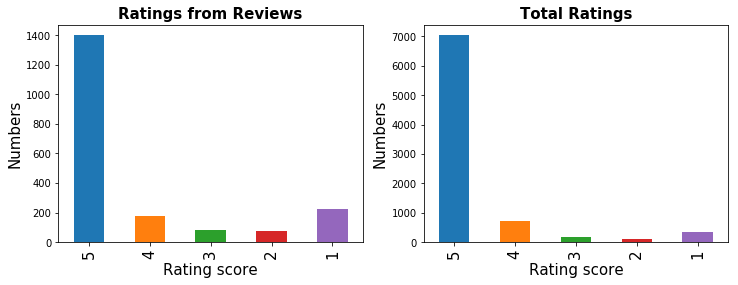

In [10]:
# See rating distribution
rating = data['Rating']
rating_count = rating.value_counts()
rating_count.sort_index(ascending=False, inplace=True)

# Ratings from all ratings
rating_all = [7047, 709, 168, 106,336]
rating_all = np.array(rating_all)

rating_all = pd.Series(rating_all, index=['5','4','3','2','1'])


fig, (ax,ax2) = plt.subplots(1,2,sharex =False, figsize=(12,4))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Rating score', fontsize=15)
ax.set_ylabel('Numbers' , fontsize=15)
ax.set_title('Ratings from Reviews', fontsize=15, fontweight='bold')
rating_count.plot(ax=ax, kind='bar')

ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=10)
ax2.set_xlabel('Rating score', fontsize=15)
ax2.set_ylabel('Numbers' , fontsize=15)
ax2.set_title('Total Ratings', fontsize=15, fontweight='bold')
rating_all.plot(ax=ax2, kind='bar')


plt.show()

In [11]:
# Arrange rating according to months
year_vec = ['2014','2015','2016','2017','2018','2019']

rate_months = pd.DataFrame(columns = ['time', 'rate_avg'])

k = 0
for i in range(len(year_vec)):
    year = year_vec[i]
    
    for i in range(1, 13):
        if i < 10:
            month = ('0'+str(i))
        else:
            month = (str(i)) 
            
        time_str = year +'-'+ month 
        
        data_tmp = data.loc[data.Date.str.contains(time_str)]
        
        if len(data_tmp) !=0:
            rate_mu = data_tmp['Rating'].mean()
            
            item = [time_str, rate_mu]
            rate_months.loc[k] = item
            
            k += 1
            

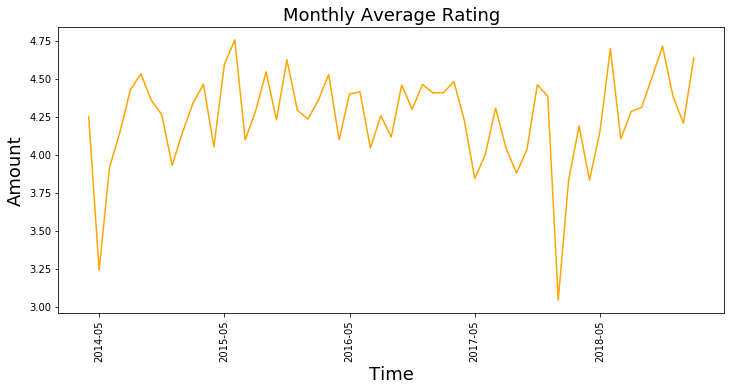

In [12]:
ax = rate_months.rate_avg.plot(xticks= rate_months.index[1:len(rate_months.index):12], rot=90, figsize=(10,5),color='orange')
ax.set_xticklabels(rate_months.time[1:len(rate_months):12],rotation=90)
plt.tight_layout()
plt.xlabel('Time',fontsize=18)
plt.ylabel('Amount',fontsize=18)
plt.title('Monthly Average Rating', fontsize = 18)            
plt.show()

In [13]:
# Load numTickets returned by proj_2_mine.py
numTickets = pd.read_csv('numTickets.csv')

# Select the overlap of two datasets: numTickets and rate_months
start_date = '2014-04'
end_date = '2018-01'
mask = (numTickets['time'] >= start_date) & (numTickets['time']<= end_date)
numTickets_sht = numTickets.loc[mask]

mask2 = (rate_months['time'] >= start_date) & (rate_months['time']<= end_date)
rate_months_sht = rate_months.loc[mask2]

numTickets_rates = pd.merge(numTickets_sht, rate_months, on= 'time', how='inner')

In [14]:
data_2 = numTickets_rates[['number','rate_avg']].copy()

indices = data_2['number'].index

data_2.loc[:,'number'] = (data_2['number'] - data_2['number'].min())/(data_2['number'].max()-data_2['number'].min()).copy()
data_2.loc[:,'rate_avg'] = (data_2['rate_avg'] - data_2['rate_avg'].min())/(data_2['rate_avg'].max()-data_2['rate_avg'].min())



## Fact 4: Expired meter tickets and ratings are inversely correlated on many points

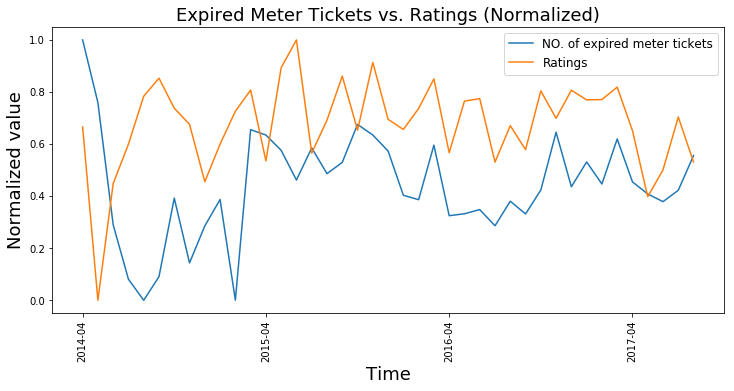

In [15]:
ax = data_2.number.plot(xticks=numTickets_rates.index[0:len(numTickets_rates.index):12], rot=90)
ax = data_2.rate_avg.plot(xticks= numTickets_rates.index[0:len(numTickets_rates.index):12], rot=90, figsize=(10,5))
ax.set_xticklabels(numTickets_rates.time[0:len(rate_months):12],rotation=90)
plt.tight_layout()
plt.xlabel('Time',fontsize=18)
plt.ylabel('Normalized value',fontsize=18)
plt.title('Expired Meter Tickets vs. Ratings (Normalized)', fontsize = 18) 
ax.legend(['NO. of expired meter tickets','Ratings'],fontsize = 12)
plt.show()

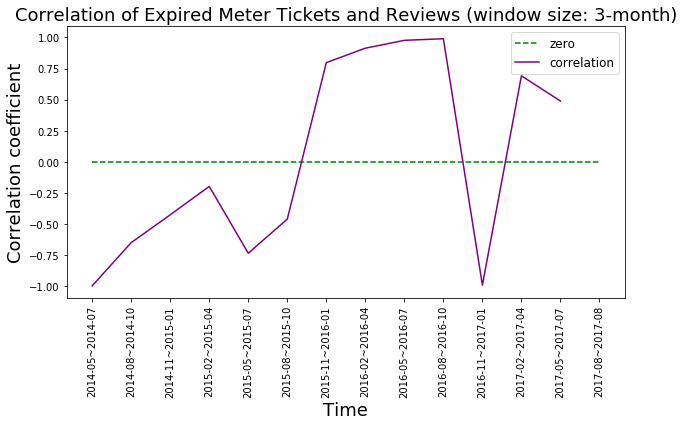

In [16]:
# Compute correlation
slidWin = 3
cor_vec = []
time_vec = []

for i in range(1, len(data_2), slidWin):
    data_tmp = data_2.iloc[i:i+slidWin,:].copy()
    #print(data_tmp)
    t_tmp = numTickets_rates.iloc[data_tmp.index, numTickets_rates.columns.get_loc('time')]
    time_str = t_tmp.values[0] +'~'+ t_tmp.values[-1]
    time_vec.append(time_str)
    
    #print(t_tmp)
    cor = data_tmp.corr()
    #print(cor)
    cor_vec.append(cor.iloc[0,1])

cor_df = pd.DataFrame(cor_vec)
base = [0] * len(cor_df)
base = pd.DataFrame(base)

fig, ax = plt.subplots(figsize = (10,5))
base.plot(ax = ax, linestyle='--', color = 'green')
cor_df.plot(ax = ax,color='purple')
ax.set_xticks(np.arange(len(time_vec)))
ax.set_xticklabels(time_vec, rotation = 90)
ax.legend(['zero','correlation'], fontsize = 12)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Correlation coefficient',fontsize=18)
plt.title('Correlation of Expired Meter Tickets and Reviews (window size: 3-month)', fontsize = 18) 
plt.show()

## Fact 5: See the summary of ParkChicago review over time

Use __TextRank algorithm__ to obtain the summary from review data (https://arxiv.org/abs/1602.03606)

### In 2014-05 (ParkChicago just released):

In [17]:
from gensim.summarization import summarize

In [18]:
# Retrieve intesting reviews
time1 = '2014-05'

#time1 = '2018-01'

def retrText(time, posFlag):
    mask = data.Date.str.contains(time)
    data_t = data[mask]
    
    if posFlag == 1:
        mask_r = (data_t['Rating'] >3)
    else:
        mask_r = (data_t['Rating'] <=2)
    data_t = data_t[mask_r]

    review_t = data_t['Review Text']

    review_t = review_t.tolist()
    text_t = ""
    for i in range(len(review_t)):
        text_t += review_t[i] + ' '
    
    return text_t

  
#print(summarize(text_t1))

* __Postive Summary__ (rating>3):

In [19]:
text_t1_pos = retrText(time1, 1)

sum1_pos = (summarize(text_t1_pos, ratio=0.1))  
print(sum1_pos)

Easy breezy Looove this app wish I can use this on every pay box It's about time we have an app for this and this one is pretty good.


* __Negative Summary__ (rating<3):

In [20]:
text_t1 = retrText(time1, 0)

sum1_neg = (summarize(text_t1, ratio=0.1))  
print(sum1_neg)

Also I don't like the idea of a pre paid account when people does not pay for parking every day.
I only uploaded this app because it was ridiculous, and very annoying to walk half a block to the machine and then have to wait for it to spit up the ticket...Full Review Charges $.35 per use!


### In 2014-07 (2 months after ParkChicago released):

* __Postive Summary__ (rating>3):

In [21]:
time2 = '2014-07'
text_t2_pos = retrText(time2, 1)

sum2_pos = (summarize(text_t2_pos, ratio=0.1))  
print(sum2_pos)

Simple to use Meters Convenient Easy Great app!
Awesome A++++++ Love that I can switch back and forth between our two cars with just a tap...so easy to extend time from anywhere!


* __Negative Summary__ ( rating<3):

In [22]:
text_t2 = retrText(time2, 0)

print(summarize(text_t2, ratio=0.1))  


App charges for time that is normally free.
"Convenience fee" on top of the exorbitant cost for parking in the first place.


## Project Plan

* GUI for temporal and spatial visualization and analysis in fine-grid
    * Temporal: over the day, week, season, and etc.  
    
    * Spatial: project temporal onto street map. 
        * *Click Button*: click map and see concerned temporal distribution
        * *Sliding-bar*: overall time
        * *Pop-up menu*: select clustering algorithm & interesting features
        
        
* Keep track of review problem automatically


* Parking garage data correlation 
    * Yelp garage review scrapping
    * How parking garage condition affect expired meter tickets


* Study other types of parking ticket data


* ...


In [23]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')